<a href="https://colab.research.google.com/github/JairEsc/Aprendizaje/blob/main/CAMDA/multi_class_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio de clasificación.
### Se consideran datos del CAMDA 2023, que se componen de abundancias de organismos de interés en muestras dada su ubicación.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
otus=pd.read_csv('camda_relative.csv', index_col=0, low_memory=False)
print(otus.shape)
otus.head()

(286, 18295)


,ID_city,City,Latitude,Longitude,Climate,Year,468,469,28090,2708348,...,1146874,1519389,12480,1131,2886895,546184,12330,1922682,1513254,1922952
ID,,,,,,,,,,,,,,,,,,,,,
CAMDA23_MetaSUB_gCSD16_AKL_10,AKL,Auckland,-36.75,174.75,Cfb,2016,0.048249,10.696605,14.560432,1.407184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_11,AKL,Auckland,-36.75,174.75,Cfb,2016,0.038155,0.527739,0.041985,0.006187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_12,AKL,Auckland,-36.75,174.75,Cfb,2016,0.002185,0.234138,0.051282,0.004188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_13,AKL,Auckland,-36.75,174.75,Cfb,2016,0.000142,0.014304,0.010763,0.001360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAMDA23_MetaSUB_gCSD16_AKL_14,AKL,Auckland,-36.75,174.75,Cfb,2016,0.002103,0.061997,0.079509,0.003771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<ipython-input-3-81df9ddf9813>:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  ax1.bar(otus['City'].value_counts().index.ravel(),otus['City'].value_counts(),)
<ipython-input-3-81df9ddf9813>:6: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  ax2.bar(otus['Climate'].value_counts().index.ravel(),otus['Climate'].value_counts())


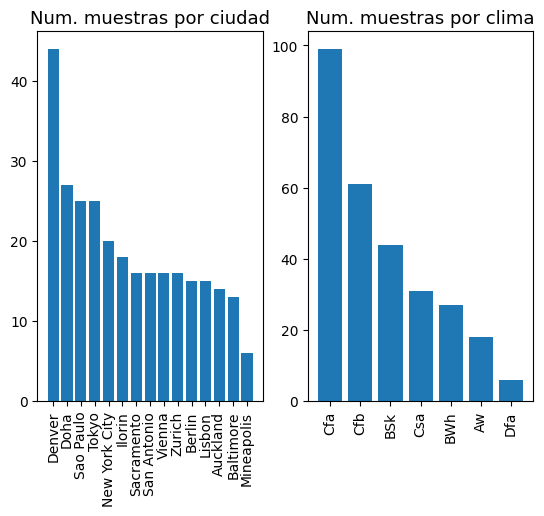

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.bar(otus['City'].value_counts().index.ravel(),otus['City'].value_counts(),)
ax1.set_title("Num. muestras por ciudad", fontsize=13)
ax1.tick_params(axis='x', labelrotation=90)

ax2.bar(otus['Climate'].value_counts().index.ravel(),otus['Climate'].value_counts())
ax2.set_title("Num. muestras por clima", fontsize=13)
ax2.tick_params(axis='x', labelrotation=90)

plt.show()

### El shape=(286,18295) nos indica que hay 286 muestras, repartidas en 15 ciudades y 7 climas.

In [4]:
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 50.4 MB/s eta 0:00:00


In [5]:
import contextily as ctx
import geopandas as gpd
import numpy as np
conteo_por_ciudad=[]
for p in otus['City'].value_counts():
  conteo_por_ciudad+=list(np.repeat(p,p))

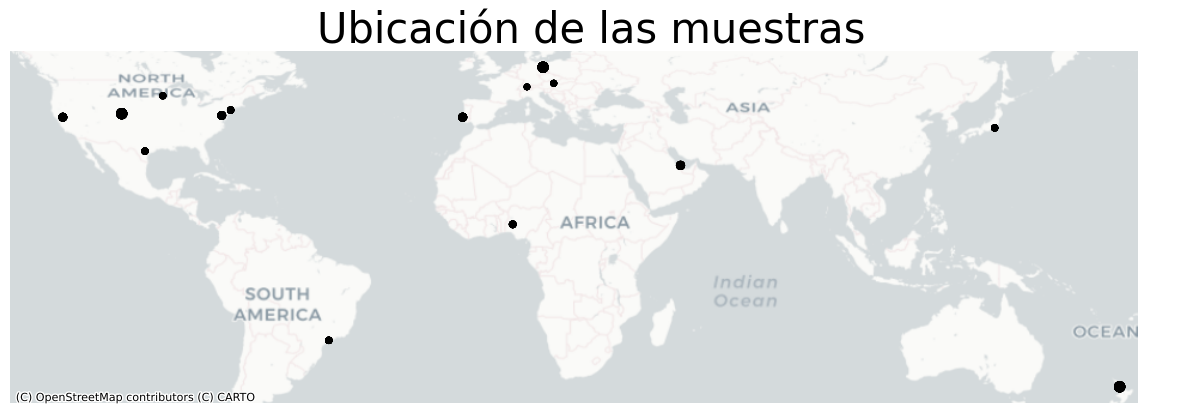

In [6]:
otus_gdf = gpd.GeoDataFrame(otus.copy(), geometry=gpd.points_from_xy(otus['Longitude'], otus['Latitude']), crs='EPSG:4326')
fig, ax = plt.subplots(1, figsize=(15, 15))
otus_gdf.plot(marker='.', c='black', ax=ax, markersize=(np.array(conteo_por_ciudad)/np.max(conteo_por_ciudad))*200, zorder=1)
plt.title("Ubicación de las muestras",fontsize=30)
plt.axis("off")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:4326')

## Trataremos de hacer las dos clasificaciones. En clima y en ciudad para comparar desempeños

## Preprocesamiento de datos

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [8]:
X_names = otus.drop(['ID_city','City','Latitude','Longitude','Climate','Year'],axis=1).columns

In [42]:
y_city = np.array(otus['City']).ravel()
X = otus[X_names]
print("Antes: ",X.shape)
for name in X_names:
    if('\x10.001308923774823973' in np.array(X[name]) or '0.001215429219479$037' in np.array(X[name]) ):
        X=X.drop(name,axis=1)
#Aquí podriamos hacer selección de muestras. E.g. aquellas etiquetas con al menos $N$ muestras.
print("Después: ",X.shape)
le = preprocessing.LabelEncoder()
le.fit(y_city)
#le.classes_
y_cat_city = le.transform(y_city)
#le.inverse_transform(y_cat[:5])

X_train, X_test, y_train, y_test = train_test_split(X, y_cat_city, test_size=0.3, random_state=0)

Antes:  (286, 18289)
Después:  (286, 18287)


In [43]:
pipe_steps = [('std', StandardScaler()), ('dim_red', PCA(n_components=5)), ('classifier', LogisticRegression(solver='newton-cg'))]
pipe = Pipeline(steps=pipe_steps)
pipe.fit(X_train, y_train)

Pipeline(steps=[('std', StandardScaler()), ('dim_red', PCA(n_components=5)),
                ('classifier', LogisticRegression(solver='newton-cg'))])

In [44]:
y_pred = pipe.predict(X_test)
target_names= otus['City'].value_counts().index.ravel()
print(metrics.classification_report(y_test, y_pred,target_names = target_names))

               precision    recall  f1-score   support

       Denver       0.20      0.25      0.22         4
         Doha       0.50      0.25      0.33         4
    Sao Paulo       0.43      0.75      0.55         4
        Tokyo       0.38      0.60      0.46        10
New York City       0.33      0.43      0.38         7
       Ilorin       0.60      0.50      0.55         6
   Sacramento       0.33      0.25      0.29         4
  San Antonio       1.00      1.00      1.00         2
       Vienna       0.00      0.00      0.00         4
       Zurich       0.67      1.00      0.80         4
       Berlin       0.67      0.29      0.40         7
       Lisbon       0.55      0.43      0.48        14
     Auckland       0.40      0.33      0.36         6
    Baltimore       0.20      0.33      0.25         3
   Mineapolis       0.20      0.14      0.17         7

     accuracy                           0.42        86
    macro avg       0.43      0.44      0.42        86
 weighte

<ipython-input-44-2281dee10110>:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  target_names= otus['City'].value_counts().index.ravel()


Está horrible.

### Lo mismo pero con climas:

In [45]:
y_climate = np.array(otus['Climate']).ravel()
le = preprocessing.LabelEncoder()
le.fit(y_climate)
y_cat_climate = le.transform(y_climate)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat_climate, test_size=0.3, random_state=0)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
target_names= otus['Climate'].value_counts().index.ravel()
print(metrics.classification_report(y_test, y_pred,target_names = target_names))


              precision    recall  f1-score   support

         Cfa       0.75      0.50      0.60         6
         Cfb       0.43      0.60      0.50        10
         BSk       0.00      0.00      0.00         7
         Csa       0.57      0.74      0.64        35
         BWh       0.25      0.22      0.24        18
          Aw       0.75      0.38      0.50         8
         Dfa       0.00      0.00      0.00         2

    accuracy                           0.49        86
   macro avg       0.39      0.35      0.35        86
weighted avg       0.45      0.49      0.46        86



<ipython-input-45-8a67e47cf359>:8: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  target_names= otus['Climate'].value_counts().index.ravel()


## Siguiente intento: redes neuronales con los datos originales (no PCA)

In [25]:
_,idx = np.unique(y_city,return_inverse=True)
from keras.utils import to_categorical
Y_total=to_categorical(idx)
X_train, X_test, y_train, y_test = train_test_split(X, Y_total, test_size=0.3, random_state=0)
import tensorflow as tf
import keras
import pandas as pd
from keras import layers
from keras import models
import tqdm
from time import time

In [32]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(18287,), name='Input_Layer'))#Obligatoria
model.add(layers.Dense(10, activation='linear'))# Numero de capas ocultas: Opcional
model.add(layers.Dense(10, activation='tanh'))# Numero de neuronas en cada capa: Opcional
model.add(layers.Dense(15, activation='Softmax', name='Output_Layer'))#Obligatoria
model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
import time
tic = time.time()

model.fit(x = X_train,
           y = y_train,
          validation_data=[X_test, y_test],batch_size=50,
           epochs=200,
           verbose=2,shuffle=True,)

print('seconds=', time.time()-tic)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 10)                182880    
                                                                 
 dense_29 (Dense)            (None, 10)                110       
                                                                 
 Output_Layer (Dense)        (None, 15)                165       
                                                                 
Total params: 183155 (715.45 KB)
Trainable params: 183155 (715.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
4/4 - 1s - loss: 2.6158 - accuracy: 0.1450 - val_loss: 2.5768 - val_accuracy: 0.1744 - 1s/epoch - 354ms/step
Epoch 2/200
4/4 - 0s - loss: 2.4769 - accuracy: 0.3100 - val_loss: 2.4799 - val_accuracy: 0.2674 - 118ms/epoch - 30ms/step
Epoch 3/200
4/4 - 0s - loss: 2.38